In [2]:
import os 
import json
import pprint
import pandas as pd
from pandas import json_normalize
import numpy as np

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from scapy.all import *



C:\Users\larad\AppData\Local\Temp\ipykernel_45192\1804849222.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\larad\AppData\Local\Programs\Python\Python311\Lib\site-packages\scapy\layers\ipsec.py:471: CryptographyDeprecationWarning: Blowfish has been deprecated
  cipher=algorithms.Blowfish,
c:\Users\larad\AppData\Local\Programs\Python\Python311\Lib\site-packages\scapy\layers\ipsec.py:485: CryptographyDeprecationWarning: CAST5 has been deprecated
  cipher=algorithms.CAST5,
ERROR: Loading module scapy.layers.ssl_tls
Traceback (most recent call last):
  File "c:\Users\larad\AppData\Local\P

In [133]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
sns.set_style("white")

def parseQlogFile(qlog_file_path, regex):
    f = open(qlog_file_path, 'r')
    qlog_data = f.read()
    f.close()

    records = qlog_data.strip().split(regex)
    parsedRecords = parseQlogDataRecords(records)

    transport_records = [record for record in parsedRecords[1:] if 'packet_sent' in record["name"] or 'packet_received' in record["name"]]
    parameters_set_records = [record for record in parsedRecords[1:] if 'parameters_set' in record["name"]]
    
    connection_establishment_handshake_time, tls_handshake_time, time_to_data_transfer = getHandshakeTimes(transport_records)
    error_reason = getError(transport_records)
    tls_established = getTLSInfo(parameters_set_records)
    zeroRTT = get0RTTPackets(transport_records)
    round_trip_times = calculateRTTQUIC(transport_records)

    if zeroRTT > 0:
        print(zeroRTT)

    return connection_establishment_handshake_time, tls_handshake_time, time_to_data_transfer, error_reason, tls_established, round_trip_times

def getHandshakeTimes(records):
    initial_packet_time = records[0]["time"]
    all_handshake_end_time = 0
    tls_handshake_packets, connection_establishment_handshake_packets = getHandshakePackets(records)

    # Get time of first data packet:
    for record in records:
        packet_type = record["data"]["header"]["packet_type"]
        if packet_type != "initial" and packet_type != "handshake":
            all_handshake_end_time = record["time"]
            break
    
    if len(connection_establishment_handshake_packets) == 0:
        return (None, None, None)
    # Get time of first data packet after connection establishment handshake:
    connection_establishment_handshake_start_time = connection_establishment_handshake_packets[0]["time"]
    connection_establishment_handshake_end_time = connection_establishment_handshake_packets[-1]["time"]
    

    if len(tls_handshake_packets) == 0:
        return (connection_establishment_handshake_end_time - connection_establishment_handshake_start_time, None, None)
    
    # Get time of first data packet after TLS handshake:
    tls_handshake_start_time = tls_handshake_packets[0]["time"]
    tls_handshake_end_time = tls_handshake_packets[-1]["time"]
    
    return (connection_establishment_handshake_end_time - connection_establishment_handshake_start_time, 
            tls_handshake_end_time - tls_handshake_start_time, 
            all_handshake_end_time - initial_packet_time)
"""
def calculateRTTQUIC(records):
    
    RTTs1, RTTs2 = 0, 0
    RTTc1, RTTc2 = 0, 0
    t1, t2, t3, t4, t5, t6, t7 = 0, 0, 0, 0, 0, 0, 0 
    avg_serverRTT = 0
    avg_clientRTT = 0
    avg_totalRTT = 0

    client_id = records[0]["data"]["header"]["scid"]
    server_id = records[0]["data"]["header"]["dcid"]

    client_rtt = []
    server_rtt = []

    packets = {}
    
    for record in records:
        #pprint.pprint(record["data"]["header"])
        if "scid" not in record["data"]["header"]:
            break
        scid = record["data"]["header"]["scid"]
        current_event = record["name"]
        current_time = record["time"]
        current_packet_num = record["data"]["header"]["packet_number"]
        current_packet_type = record["data"]["header"]["packet_type"]

        if current_packet_type not in packets:
            packets[current_packet_type] = {}

        #print(scid, current_event)
         # Check if it's a packet sent event
        if current_event == 'transport:packet_sent':
            if current_packet_num not in packets[current_packet_type]:
                packets[current_packet_type][current_packet_num] = [current_time]
            else:
                break
            #packet_sent_time = current_time
        # Check if it's a packet received event
        elif current_event == 'transport:packet_received':
            if current_packet_num in packets[current_packet_type]:
                packets[current_packet_type][current_packet_num].append(current_time)

                if scid == client_id:
                    client_rtt.append(packets[current_packet_type][current_packet_num][1] - packets[current_packet_type][current_packet_num][0])
                else:
                    server_rtt.append(packets[current_packet_type][current_packet_num][1] - packets[current_packet_type][current_packet_num][0])
            else:
                break
            #packet_received_time = current_time
            # Calculate RTT and append to client or server RTT list based on vantage point
            

    #print("client RTT")
    #pprint.pprint(client_rtt)
    #print("server RTT")
    #pprint.pprint(server_rtt)
    avg_clientRTT = np.mean(client_rtt) if len(client_rtt) > 1 else None
    avg_serverRTT = np.mean(server_rtt) if len(server_rtt) > 1 else None
    avg_totalRTT = None

    if avg_clientRTT and avg_serverRTT:
        avg_totalRTT = (avg_clientRTT + avg_serverRTT) / 2
    else:
        clientRTT = client_rtt[0] if len(client_rtt) > 0 else None
        serverRTT = server_rtt[0] if len(server_rtt) > 0 else None
        # if client has avg but server does not
        if avg_clientRTT:
            # if server has an RTT measurement
            if len(server_rtt) > 0:
                client_rtt.append(server_rtt[0])
                avg_totalRTT = np.mean(client_rtt)
            else:
                avg_totalRTT = None
        # if server has avg but client does not
        elif avg_serverRTT:
            # if client has an RTT measurement
            if len(client_rtt) > 0:
                server_rtt.append(client_rtt[0])
                avg_totalRTT = np.mean(server_rtt)
            else:
                avg_totalRTT = None
        # if client and server only have one RTT each
        elif serverRTT and clientRTT:
            avg_totalRTT = np.mean([serverRTT, clientRTT])
    
    return {"Avg Server RTT" : avg_serverRTT, 
            "Avg Client RTT" : avg_clientRTT, 
            "Avg Total RTT" : avg_totalRTT}
"""

"""
def calculateRTTQUIC(records):

    client_id = records[0]["data"]["header"]["scid"]
    server_id = records[0]["data"]["header"]["dcid"]
    #print(client_id, server_id)

    client_sent = {}
    client_received = {}
    server_sent = {}
    server_received = {}

    for record in records:
        #pprint.pprint(record["data"]["header"])
        if "scid" not in record["data"]["header"]:
            break

        scid = record["data"]["header"]["scid"]
        current_event = record["name"]
        packet_time = record["time"]
        packet_number = record["data"]["header"]["packet_number"]
        packet_type = record["data"]["header"]["packet_type"]

         # Check if it's a packet sent event
        if current_event == 'transport:packet_sent':
            if scid == client_id:
                client_sent[(packet_type, packet_number)] = packet_time
            elif scid in server_id:
                server_sent[(packet_type, packet_number)] = packet_time
        # Check if it's a packet received event
        elif current_event == 'transport:packet_received':
            if scid == client_id:
                client_received[(packet_type, packet_number)] = packet_time
            elif scid in server_id:
                server_received[(packet_type, packet_number)] = packet_time

    client_rtt = []
    server_rtt = []

    # Calculate client -> server rtt
    for key in client_sent:
        if key in server_received:
            client_sent_time = client_sent[key]
            server_received_time = server_received[key]
            if key[0] == "initial":
                rtt = server_received_time - client_sent_time
            else: 
                rtt = client_sent_time - server_received_time
            #print("client -> server")
            #print(client_sent_time, server_received_time)
            #print(f"Packet Type: {key[0]}, Packet Number: {key[1]}, RTT: {rtt}")
            client_rtt.append(rtt)
    
    # Calculate server -> client rtt
    for key in server_sent:
        if key in client_received:
            server_sent_time = server_sent[key]
            client_received_time = client_received[key]
            if key[0] == "initial":
                rtt = server_sent_time - client_received_time
            else:
                rtt = client_received_time - server_sent_time
            #print("server -> client")
            #print(server_sent_time, client_received_time)
            #print(f"Packet Type: {key[0]}, Packet Number: {key[1]}, RTT: {rtt}")
            server_rtt.append(rtt)
    
    avg_serverRTT = np.mean(server_rtt) if len(server_rtt) > 0 else None
    avg_clientRTT = np.mean(client_rtt) if len(client_rtt) > 0 else None
    avg_totalRTT = (avg_serverRTT + avg_clientRTT) / 2 if avg_serverRTT and avg_clientRTT else None

    return {"Avg Server RTT" : avg_serverRTT, 
            "Avg Client RTT" : avg_clientRTT, 
            "Avg Total RTT" : avg_totalRTT}
"""

def calculateRTTQUIC(records):

    packets_acked = {} # {initial: {0 : [time_sent, time_acked], 1: [time_sent, time_acked]}, handshake: {}}
    rtt = []

    for record in records:
        
        packet_time = record["time"]
        packet_number = int(record["data"]["header"]["packet_number"])
        packet_type = record["data"]["header"]["packet_type"]

        #print(packet_type, packet_number)

        if "frames" in record["data"]:
            for frame in record["data"]["frames"]:
                if frame["frame_type"] == "ack":
                    acked_ranges = frame["acked_ranges"]
                    #print(acked_ranges)

                    for ack_range in acked_ranges:
                        ack_min = int(ack_range[0])
                        ack_max = int(ack_range[1]) if len(ack_range) > 1 else int(ack_range[0])
                        for i in range(ack_min, ack_max + 1):
                            #print("acking packet... ", i)
                            # if a packet with this type & num has been sent, and has not yet been acked
                            if i in packets_acked[packet_type]and len(packets_acked[packet_type][i]) == 1:
                                packets_acked[packet_type][i].append(packet_time)

        # Record the time packet is sent by client / received by server :
                                
        # if no packets of this type have been sent yet
        if packet_type not in packets_acked:
            packets_acked[packet_type] = {packet_number : [packet_time]}
        # if packets of this type have been sent, but not with this packet number
        elif packet_number not in packets_acked[packet_type]:
            packets_acked[packet_type][packet_number] = [packet_time]

    
    #pprint.pprint(packets_acked)
    
    for packet_type in packets_acked:
        for packet_num in packets_acked[packet_type]:
            if len(packets_acked[packet_type][packet_num]) > 1:
                time_sent = packets_acked[packet_type][packet_num][0]
                time_acked = packets_acked[packet_type][packet_num][1]
                rtt.append(time_acked - time_sent)

    avgRTT = np.mean(rtt) if len(rtt) > 0 else None

    return avgRTT

def getHandshakePackets(records):
    tls_handshake_packets = []
    connection_establishment_handshake_packets = []

    for record in records:
        packet_type = record["data"]["header"]["packet_type"]
        if packet_type == "handshake":
            for frame in record["data"]["frames"]:
                if frame["frame_type"] == "crypto":
                    #print("TLS PACKET")
                    #pprint.pprint(record)
                    tls_handshake_packets.append(record)
                else:
                    #print("CONNECTION ESTABLISHMENT PACKET")
                    #pprint.pprint(record)
                    connection_establishment_handshake_packets.append(record)
    return tls_handshake_packets, connection_establishment_handshake_packets


def getError(records):
    error_reason = ""
    for record in records:
        if "frames" in record["data"]:
            for frame in record["data"]["frames"]:
                if frame["frame_type"] == "connection_close":
                    error_reason = frame["reason"]
                    break
    return error_reason

def getTLSInfo(records):
    tls_ciphers = []
    for record in records:
        if "tls_cipher" in record["data"]:
            tls_ciphers.append(record["data"]["tls_cipher"])
    return tls_ciphers

def get0RTTPackets(records):
    num_of_0RTT_packets = 0
    for record in records:
        packet_type = record["data"]["header"]["packet_type"]
        if packet_type == "0RTT":
            num_of_0RTT_packets += 1
    return num_of_0RTT_packets

def parseQlogDataRecords(qlog_data):
   json_data = [json.loads(string.strip()) for string in qlog_data]
   return json_data

def createDictionary(parsed_data):
    data_dict = {}

    for data in parsed_data:
        if type(data) == dict:
            for key, value in data.items():
                if key not in data_dict:
                    data_dict[key] = [value]
                else:
                    if type(value) == dict:
                        data_dict[key].append(createDictionary(value))
                    else:
                        data_dict[key].append(value)
        else:
            return parsed_data

    
    #pprint.pprint(data_dict)
    return data_dict

def displayPandasTable(parsedRecords):
    flattened_header_data = createDictionary(parsedRecords[0])
    flattened_header_data2 = createDictionary(parsedRecords[1])
    flattened_data = createDictionary(parsedRecords[1:])

    df1 = pd.DataFrame(flattened_header_data)
    df2 = pd.DataFrame(flattened_header_data2)
    #df = pd.DataFrame({k: [flattened_data.get(k, None)] for k in keys})
    df = pd.DataFrame(flattened_data)

    df = df.fillna('')

    display(df1)
    display(df2)
    display(df)
    

def getMeanTime(times):
    return np.mean([time for time in times if time != None])

def generateOverlappedHandshakeTimeDistribution(handshake_data_quic, handshake_data_tcp, type=1):
    bins_quic = []
    bins_tcp = []
    data_quic = {"home":[], "campus": []}
    data_tcp = {"home":[], "campus": []}

    for location in handshake_data_quic:
        max_time = 0
        for url,time in handshake_data_quic[location].items():
            if time != None:
                data_quic[location].append(time)
                if time > max_time:
                    max_time = time
        bins_quic.append(int(max_time // 5))
    
    for location in handshake_data_tcp:
        max_time = 0
        for url,time in handshake_data_tcp[location].items():
            if time != None:
                data_tcp[location].append(time)
                if time > max_time:
                    max_time = time
        bins_tcp.append(int(max_time // 5))

    print(bins_quic, bins_tcp)
    showHistPlotQUICvTCP(data_quic, data_tcp, bins_quic, bins_tcp, type)

def showHistPlotQUICvTCP(data_quic, data_tcp, bins_quic, bins_tcp, type):
    sns.set_palette("colorblind")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True, dpi=100)

    #fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    sns.histplot(data_tcp["home"], label="TCP", bins=bins_tcp[0], ax=axes[0], kde=True, alpha=0.5, stat='percent',) #log_scale=True
    sns.histplot(data_quic["home"], label="QUIC", bins=bins_quic[0], ax=axes[0], kde=True, alpha=0.5, stat='percent',) #log_scale=True
    axes[0].set_title('Measurements taken from Location 1', fontsize=16)
    axes[0].grid(True)

    #fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    sns.histplot(data_tcp["campus"], label="TCP", bins=bins_tcp[1], ax=axes[1], legend=True, kde=True, alpha=0.5, stat='percent',) #log_scale=True
    sns.histplot(data_quic["campus"], label="QUIC", bins=bins_quic[1], ax=axes[1], legend=True, kde=True, alpha=0.5, stat='percent',) #log_scale=True
    axes[1].set_title('Measurements taken from Location 2', fontsize=16)
    axes[1].grid(True)

    if type == 1:
        axes[0].set_xlabel('Duration of Handshake (ms)', fontsize=14)
        axes[0].set_ylabel('Percentage of Connections (%)', fontsize=14)
        axes[1].set_xlabel('Duration of Handshake (ms)', fontsize=14)

        axes[0].set_xlim(0, 200)
        axes[1].set_xlim(0, 200)
        axes[0].set_ylim(0, 45)
        axes[1].set_ylim(0, 45)

        plt.suptitle(f'Duration of Connection Establishment Handshake: QUIC vs TCP', fontsize=20, fontweight='bold')
    else:
        axes[0].set_xlabel('Time taken (ms)', fontsize=14)
        axes[0].set_ylabel('Percentage of URLs (%)', fontsize=14)
        axes[1].set_xlabel('Time taken (ms)', fontsize=14)

        axes[0].set_xlim(0, 400)
        axes[1].set_xlim(0, 400)
        axes[0].set_ylim(0, 35)
        axes[1].set_ylim(0, 35)
        plt.suptitle(f'Time elapsed before initiating data transfer: QUIC vs TCP', fontsize=20, fontweight='bold')
        
    
    plt.tight_layout()
    plt.legend()
    plt.show()

def generateHandshakeTimeDistribution(handshake_data, proto=""):
    bins = []
    data = {"home":{"urls": [], "times":[]}, "campus": {"urls": [], "times":[]}}
    for location in handshake_data:
        max_time = 0
        for url,time in handshake_data[location].items():
            if time != None:
                data[location]["urls"].append(url)
                data[location]["times"].append(time)
                
                if time > max_time:
                    max_time = time
        bins.append(int(max_time // 5))
    print(bins)
    showHistPlot(data, bins, proto)

                       
def showHistPlot(data, bins, proto):    
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True, sharex=True, dpi=100)
    
    sns.histplot(data["home"]["times"], color="dodgerblue", label="home", bins=bins[0], ax=axes[0], legend=True, kde=True) #log_scale=True
    axes[0].set_title('Measurements taken from Location 1')
    axes[0].set_xlabel('Time (ms)')
    axes[0].set_ylabel('Count')
    axes[0].grid(True)

    sns.histplot(data["campus"]["times"], color="deeppink", label="campus", bins=bins[1], ax=axes[1], legend=True, kde=True) #log_scale=True
    axes[1].set_title('Measurements taken from Location 2')
    axes[1].set_xlabel('Time (ms)')
    axes[1].grid(True)

    # Set x-axis limit for both subplots
    x_limit = 400  # Example limit
    axes[0].set_xlim(0, x_limit)
    axes[1].set_xlim(0, x_limit)

    plt.suptitle(f"Time elapsed before initiating data transmission with {proto}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def getTLSErrors(error_reasons):
    count_errors = {}
    for location in error_reasons:
        for k, v in error_reasons[location].items():
            if v != '':
                if v in count_errors:
                    count_errors[v][location] += 1
                else:
                    if location == "home":
                        count_errors[v] = {"home": 1, "campus": 0}
                    else:
                        count_errors[v] = {"home": 0, "campus": 1}
    
    data = []
    for error, counts in count_errors.items():
        data.append((error, counts["home"], counts["campus"]))

    columns = pd.MultiIndex.from_tuples([('Error', ''), ('Location', 'home'), ('Location', 'campus')])
    df = pd.DataFrame(data, columns=columns).fillna(0)
    display(df)   


def getTLSEstablishedInfo(tls_established):    
    tls_ciphers = {}
    for location in tls_established:
        for k, v in tls_established[location].items():
            for cipher in v:
                if cipher in tls_ciphers:
                    tls_ciphers[cipher][location] += 1
                else:
                    if location == "home":
                        tls_ciphers[cipher] = {"home": 1, "campus": 0}
                    else:
                        tls_ciphers[cipher] = {"home": 0, "campus": 1}

    data = []
    for cipher, counts in tls_ciphers.items():
        if cipher != "None":
            data.append((cipher, counts["home"], counts["campus"]))

    columns = pd.MultiIndex.from_tuples([('TLS Cipher', ''), ('Location', 'home'), ('Location', 'campus')])
    df = pd.DataFrame(data, columns=columns).fillna(0)
    display(df)
    

In [134]:
# Global variable declarations
regex = chr(30)

locations = ["home", "campus"]

handshake_times = {l:{} for l in locations}
tls_handshake_times = {l:{} for l in locations}

time_to_data_transfer = {l:{} for l in locations}

error_reasons = {l:{} for l in locations}
tls_established = {l:{} for l in locations}
round_trip_times_quic = {l:{} for l in locations}

In [135]:
current_location = locations[0]
# Folder Path 
path = f"C:/Users/larad/Documents/l4project/data/packetCapture_{current_location}/quic"
# Change the directory 
os.chdir(path) 

# iterate through all file 
for folder in os.listdir(): 
    folder_path = f"{path}/{folder}"
    os.chdir(folder_path)
    
    for file in os.listdir():
        # Check whether file is in sqlog format or not 
        if file.endswith(".sqlog"): 
            handshake_times[current_location][folder], tls_handshake_times[current_location][folder], time_to_data_transfer[current_location][folder], error_reasons[current_location][folder], tls_established[current_location][folder], round_trip_times_quic[current_location][folder] = parseQlogFile(f"{folder_path}/{file}", regex)
            break
        #elif file.endswith(".pcap"): 
        #    round_trip_times_quic[current_location][folder] = parseQUICPcapFile(f"{folder_path}/{file}")

#pprint.pprint(round_trip_times_quic)

In [136]:
current_location = locations[1]

# Folder Path 
path = f"C:/Users/larad/Documents/l4project/data/packetCapture_{current_location}/quic"
# Change the directory 
os.chdir(path) 

# iterate through all file 
for folder in os.listdir(): 
    folder_path = f"{path}/{folder}"
    os.chdir(folder_path)
    
    for file in os.listdir():
        # Check whether file is in sqlog format or not 
        if file.endswith(".sqlog"): 
            handshake_times[current_location][folder], tls_handshake_times[current_location][folder], time_to_data_transfer[current_location][folder], error_reasons[current_location][folder], tls_established[current_location][folder], round_trip_times_quic[current_location][folder] = parseQlogFile(f"{folder_path}/{file}", regex)
            break

In [137]:
#print("Average time to complete handshake: ", getMeanTime(handshake_times), "ms")
#generateHandshakeTimeDistribution(handshake_times)
#generateHandshakeTimeDistribution(handshake_times, 1, "Connection Establishment", "QUIC")
#generateHandshakeTimeDistribution(tls_handshake_times, 1, "TLS", "QUIC")
pprint.pprint(round_trip_times_quic)

{'campus': {'www.163.com': None,
            'www.1688.com': 6.557518084745754,
            'www.500px.com': None,
            'www.aarp.org': None,
            'www.abc.net.au': 46.345891,
            'www.abcnews.go.com': 6.07955661764706,
            'www.about.com': None,
            'www.about.me': 8.782123,
            'www.aboutads.info': None,
            'www.aboutcookies.org': 3.156028078947367,
            'www.academia.edu': None,
            'www.accenture.com': None,
            'www.accor.com': None,
            'www.accuweather.com': 15.156650999999998,
            'www.acm.org': 10.148043,
            'www.acs.org': 2.4098012386363625,
            'www.addthis.com': 20.042957,
            'www.addtoany.com': 4.8955928666666635,
            'www.admin.ch': None,
            'www.adobe.com': 3.718711714285713,
            'www.adweek.com': 5.747323672899617,
            'www.ahmuseum.org': None,
            'www.ai-lawandorder.com': None,
            'www.airbnb.com': 4.

In [5]:


"""
TLS:

parameters_set
key_updated & key_discarded : tls can trigger
crypto_error

packet_received, raw, frames -> [{frame_type: "connection_close", "reason": "CONTAINS TLS"}]
handshake_failure: Indicates that the sender was unable to negotiate an acceptable set of security parameters 
given the options available. This is a fatal error.

internal_error: An internal error unrelated to the peer or the correctness of the protocol makes it impossible 
to continue, such as a memory allocation failure. The error is not related to protocol. 
This message is always fatal.

"""

'\nTLS:\n\nparameters_set\nkey_updated & key_discarded : tls can trigger\ncrypto_error\n\npacket_received, raw, frames -> [{frame_type: "connection_close", "reason": "CONTAINS TLS"}]\nhandshake_failure: Indicates that the sender was unable to negotiate an acceptable set of security parameters \ngiven the options available. This is a fatal error.\n\ninternal_error: An internal error unrelated to the peer or the correctness of the protocol makes it impossible \nto continue, such as a memory allocation failure. The error is not related to protocol. \nThis message is always fatal.\n\n'

In [138]:
def parsePcapFile(path):
    packets = rdpcap(path)
    load_layer("tls")

    connection_establishment_handshake_duration, time_before_data_transfer = findHandshakeTime(packets)
    tls_packets = findTLSPackets(packets)
    round_trip_times = calculateRTT(packets)
    #tls_handshake_time = findTLSHandshakeTime(tls_packets)
    #print(tls_packets)
    return connection_establishment_handshake_duration, time_before_data_transfer, tls_packets, round_trip_times

def findHandshakeTime(packets):
    handshake_complete = False
    time_of_first_handshake_packet = 0
    time_of_last_handshake_packet = 0
    initial_time = packets[0].time
    for pkt in packets:
        #print(pkt.summary())
        #print(pkt.src, pkt.dst, pkt.proto, pkt.time)
        #pprint.pprint(pkt.payload)
        if handshake_complete:
            connection_establishment_handshake_duration = (time_of_last_handshake_packet - time_of_first_handshake_packet) * 1000
            time_before_data_transfer = (float(pkt.time) - initial_time) * 1000
            if time_before_data_transfer < 0:
                return None, None
            return connection_establishment_handshake_duration, time_before_data_transfer
        #pprint.pprint(pkt)
        if TCP in pkt:
            #src_ip = pkt[IP].src
            #dst_ip = pkt[IP].dst
            #print(src_ip, dst_ip)
            flag = pkt[TCP].flags
            if flag == "S":
                time_of_first_handshake_packet = float(pkt.time)
            elif flag == "A":
                handshake_complete = True
                time_of_last_handshake_packet = float(pkt.time)

def findTLSPackets(packets):
    tls_packets = [x[TLS] for x in packets if TLS in x]
    return tls_packets

def calculateRTT(packets):
    if len(packets) == 0:
        return None, None, None
    
    RTTs1, RTTs2 = 0, 0
    RTTc1, RTTc2 = 0, 0
    t1, t2, t3, t4, t5, t6, t7 = 0, 0, 0, 0, 0, 0, 0 
    avg_serverRTT = 0
    avg_clientRTT = 0
    avg_totalRTT = 0

    if IP in packets[0]:
        client_ip = packets[0][IP].src
        server_ip = packets[0][IP].dst
    else:
        return None
    
    for pkt in packets:
        #pprint.pprint(pkt)
        if IP in pkt:
            source_ip = pkt[IP].src
        else:
            break

        # packets from client -> server
        if source_ip == client_ip and t1 == 0:
            t1 = pkt.time
        elif source_ip == client_ip and t3 == 0:
            t3 = pkt.time
        elif source_ip == client_ip and t4 == 0:
            t4 = pkt.time
        elif source_ip == client_ip and t7 == 0:
            t7 = pkt.time
        
        # packets from server -> client
        if source_ip == server_ip and t2 == 0:
            t2 = pkt.time
        elif source_ip == server_ip and t5 == 0:
            t5 = pkt.time
        elif source_ip == server_ip and t6 == 0:
            t6 = pkt.time
        

        # calculate server RTT
        if t2 > 0 and t1 > 0 and RTTs1 == 0:
            RTTs1 = t2 - t1
        elif t4 > 0 and t5 > 0 and RTTs2 == 0:
            RTTs2 = t5 - t4
        
        # calculate client RTT
        if t3 > 0 and t2 > 0 and RTTc1 == 0:
            RTTc1 = t3 - t2
        elif t7 > 0 and t6 > 0 and RTTc2 == 0:
            RTTc2 = t7 - t6

    avg_serverRTT = (RTTs1 + RTTs2) / 2
    avg_clientRTT = (RTTc1 + RTTc2) / 2
    avg_totalRTT = avg_serverRTT + avg_clientRTT

    #print(t1, t2, t3, t4, t5, t6, t7)
    #print(RTTs1, RTTs2, RTTc1, RTTc2)
    return {"Avg Server RTT" : avg_serverRTT, 
            "Avg Client RTT" : avg_clientRTT, 
            "Avg Total RTT" : avg_totalRTT}

"""def findRTT(path):
    subprocess.run(["tshark", "-r", path, "-Y", "-T", "-e", "tcp.analysis.ack_rtt"], check=True)"""

def findTLSHandshakeTime(packets):
    initial_time = 0
    end_time = packets[-1].time

    for pkt in packets:
        tls_record = pkt[TLS]
        if TLSClientHello in tls_record.msg[0]:
            initial_time = pkt.time
        elif TLSFinished in tls_record.msg[0]:
            end_time = pkt.time
             
    print(end_time, initial_time)
    return abs(end_time - initial_time)
        

In [139]:
handshake_times_tcp = {l:{} for l in locations}
time_before_data_transfer_tcp = {l:{} for l in locations}
tls_packets = {l:{} for l in locations}
round_trip_times_tcp = {l:{} for l in locations}

In [140]:
current_location = locations[0]
# Folder Path 
path = f"C:/Users/larad/Documents/l4project/data/packetCapture_{current_location}/tcp"
# Change the directory 
os.chdir(path) 

# iterate through all file 
for folder in os.listdir(): 
    folder_path = f"{path}/{folder}"
    os.chdir(folder_path)
    
    for file in os.listdir():
        # Check whether file is in pcap format or not 
        if file.endswith(".pcap") and os.path.getsize(f"{folder_path}/{file}") > 0: 
            handshake_times_tcp[current_location][folder], time_before_data_transfer_tcp[current_location][folder], tls_packets[current_location][folder], round_trip_times_tcp[current_location][folder] = parsePcapFile(f"{folder_path}/{file}")
            #tcp_RTT_data = findRTT(f"{folder_path}/{file}")
            #print(tcp_RTT_data)
            break

In [141]:
current_location = locations[1]
# Folder Path 
path = f"C:/Users/larad/Documents/l4project/data/packetCapture_{current_location}/tcp"
# Change the directory 
os.chdir(path) 

# iterate through all file 
for folder in os.listdir(): 
    folder_path = f"{path}/{folder}"
    os.chdir(folder_path)
    
    for file in os.listdir():
        # Check whether file is in pcap format or not 
        if file.endswith(".pcap") and os.path.getsize(f"{folder_path}/{file}") > 0: 
            handshake_times_tcp[current_location][folder], time_before_data_transfer_tcp[current_location][folder], tls_packets[current_location][folder], round_trip_times_tcp[current_location][folder]  = parsePcapFile(f"{folder_path}/{file}")
            break

In [146]:
def parseTCPRTTdata(rtt_data):
    overall_rtt_data = {'Avg Overall Client RTT': [], 
                        'Avg Overall Server RTT': [], 
                        'Avg Overall Total RTT': []}
    for location in rtt_data:
        for website in rtt_data[location]:
            #print(rtt_data[location])
            #print("client" , rtt_data[location][website]['Avg Client RTT'])
            if rtt_data[location][website]['Avg Client RTT']:
                overall_rtt_data['Avg Overall Client RTT'].append(float(rtt_data[location][website]['Avg Client RTT']))
            #print("server" , rtt_data[location][website]['Avg Server RTT'])
            if rtt_data[location][website]['Avg Server RTT']:
                overall_rtt_data['Avg Overall Server RTT'].append(float(rtt_data[location][website]['Avg Server RTT']))
            #print("total" , rtt_data[location][website]['Avg Total RTT'])
            if rtt_data[location][website]['Avg Total RTT']:
                overall_rtt_data['Avg Overall Total RTT'].append(float(rtt_data[location][website]['Avg Total RTT']))
    
    overall_rtt_data['Avg Overall Client RTT'] = np.mean(overall_rtt_data['Avg Overall Client RTT']) * 1000
    overall_rtt_data['Avg Overall Server RTT'] = np.mean(overall_rtt_data['Avg Overall Server RTT']) * 1000
    overall_rtt_data['Avg Overall Total RTT'] = np.mean(overall_rtt_data['Avg Overall Total RTT']) * 1000

    return overall_rtt_data

def parseQUICRTTdata(rtt_data):
    overall_rtt_data = []
    for location in rtt_data:
        for website in rtt_data[location]:
            if rtt_data[location][website]:
                overall_rtt_data.append(float(rtt_data[location][website]))

    return np.mean(overall_rtt_data)



overall_rtt_tcp = parseTCPRTTdata(round_trip_times_tcp)
overall_rtt_quic = parseQUICRTTdata(round_trip_times_quic)
print(overall_rtt_tcp)
print(overall_rtt_quic)

{'Avg Overall Client RTT': 1.27442047330765, 'Avg Overall Server RTT': 27.19268684645019, 'Avg Overall Total RTT': 28.46710731975784}
19.498673421660556


[95, 210]


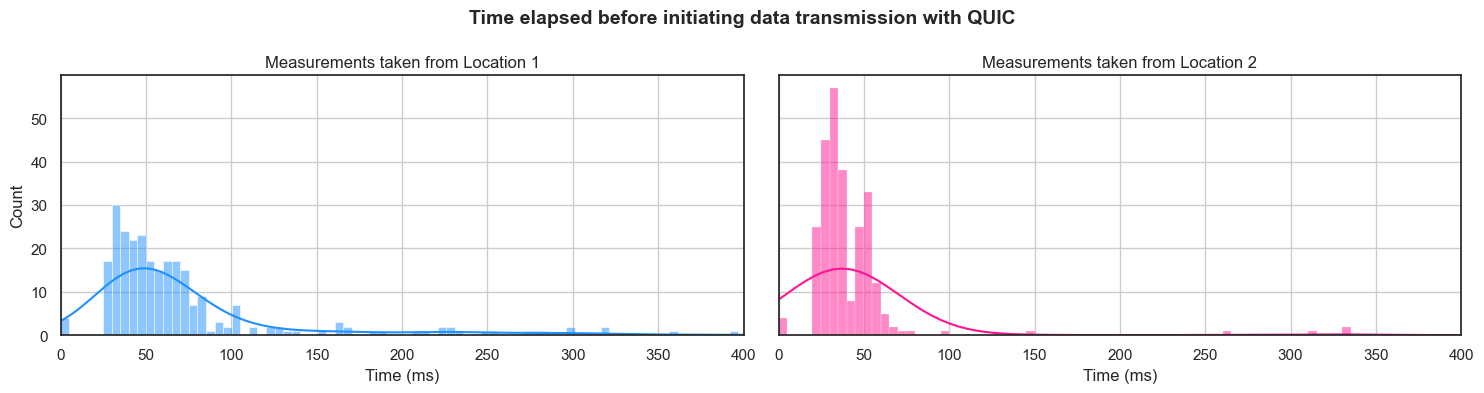

[218, 257]


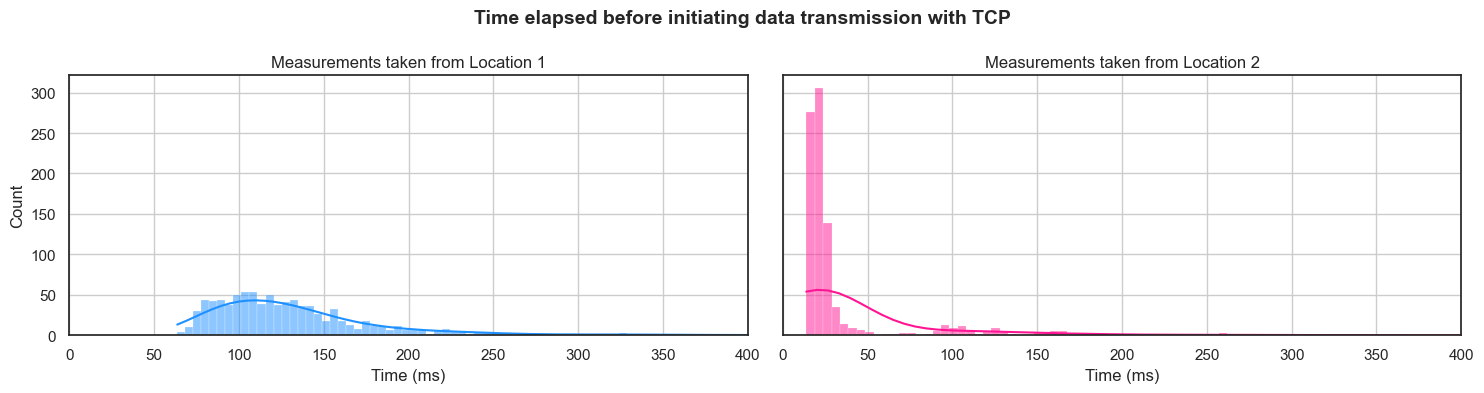

[39, 17] [205, 96]


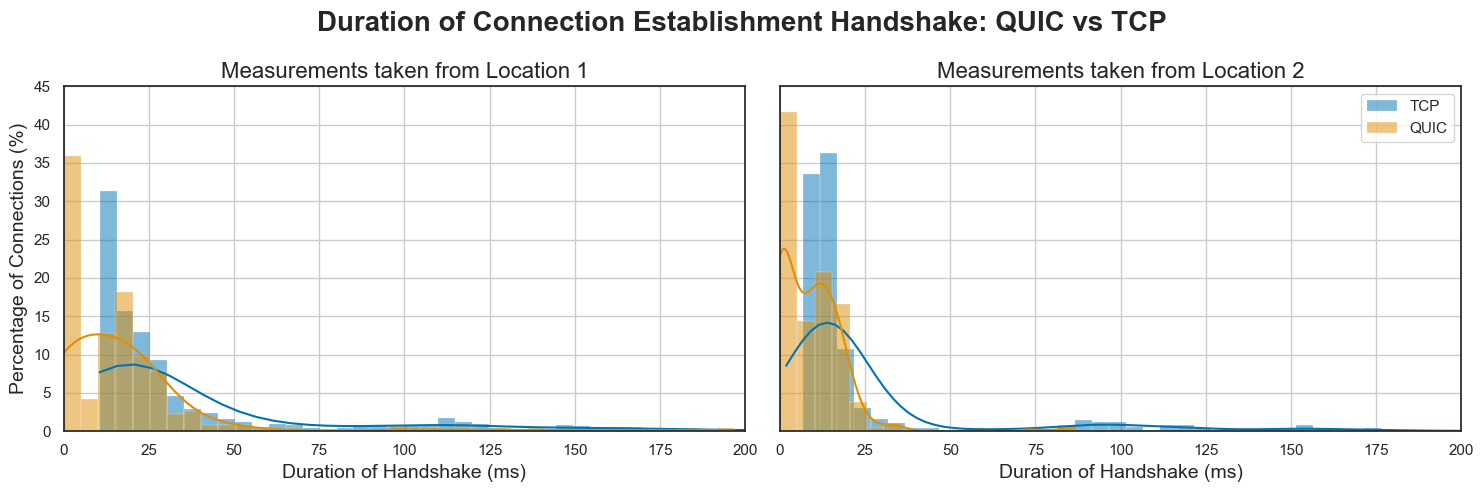

[95, 210] [218, 257]


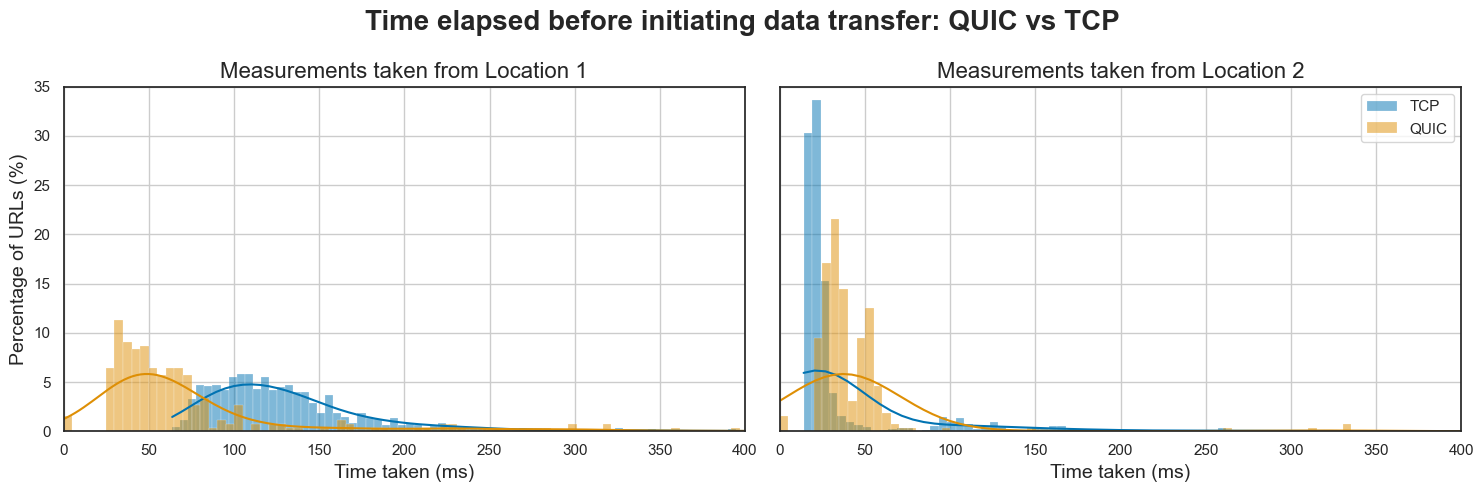

In [63]:
#pprint.pprint(handshake_times)
#generateHandshakeTimeDistribution(handshake_times_tcp, 1, "Connection Establishment", "TCP")
#generateHandshakeTimeDistribution(handshake_times_tcp_tls, 1, "Security", "TLS")
generateHandshakeTimeDistribution(time_to_data_transfer, proto="QUIC")
generateHandshakeTimeDistribution(time_before_data_transfer_tcp, proto="TCP")

generateOverlappedHandshakeTimeDistribution(handshake_times, handshake_times_tcp)
generateOverlappedHandshakeTimeDistribution(time_to_data_transfer, time_before_data_transfer_tcp, type=2)

In [88]:
"""pprint.pprint(tls_packets["home"]["www.ebay.com"][0])
print("ClientHello: ", tls_packets["home"]["www.ebay.com"][0].msg[0].ciphers)
pprint.pprint(tls_packets["home"]["www.ebay.com"][1])
print("ServerHello: ", tls_packets["home"]["www.ebay.com"][1].msg[0].cipher)"""

def findTLSVersionAndCiphers():
    tls_versions = {}
    tls_ciphers = {}

    for location in tls_packets:
        for website in tls_packets[location]:
            if len(tls_packets[location][website]) > 1:
                pkt = tls_packets[location][website][1]
                if pkt[TLS].msg:
                    
                    version = pkt[TLS].version if hasattr(pkt[TLS], 'version') else None
                    cipher = pkt[TLS].msg[0].cipher if hasattr(pkt[TLS].msg[0], 'cipher') else None

                    # TLS version
                    if version:
                        if version not in tls_versions:
                            if location == "home":
                                tls_versions[version] = {"home":1, "campus":0}
                            else:
                                tls_versions[version] = {"home":0, "campus":1}
                        else:
                            tls_versions[version][location] += 1
                    # TLS cipher
                    if cipher:
                        if cipher not in tls_ciphers:
                            if location == "home":
                                tls_ciphers[cipher] = {"home":1, "campus":0}
                            else:
                                tls_ciphers[cipher] = {"home":0, "campus":1}
                        else:
                            tls_ciphers[cipher][location] += 1

    return tls_versions, tls_ciphers


def findTLSHandshakeMessages():
    tls_connections = {"(1)client_hello":{"home":0, "campus":0}, 
                       "(2)server_hello":{"home":0, "campus":0}, 
                       "(3)server_key_exchange":{"home":0, "campus":0}, 
                       "(4)client_key_exchange":{"home":0, "campus":0}, 
                       "(5)change_cipher_spec":{"home":0, "campus":0}, 
                       "(6)finished":{"home":0, "campus":0}, 
                       "tls_alert":{"home":0, "campus":0}, 
                       "alert_before_key_exchange":{"home":0, "campus":0}, 
                       "alert_during_key_exchange":{"home":0, "campus":0}, 
                       }
    loc_count = {"home":0, "campus":0}

    for location in tls_packets:
        for website in tls_packets[location]:

            client_hello = False
            server_hello = False
            server_key_exchange = False
            client_key_exchange = False
            change_cipher_spec = False
            finished = False
            alert = False
            alert_before_key_exchange = False
            alert_during_key_exchange = False

            current_cipher = ''

            for pkt in tls_packets[location][website]:

                tls_record = pkt[TLS]

                if tls_record.msg:
                    cipher = pkt[TLS].msg[0].cipher if hasattr(pkt[TLS].msg[0], 'cipher') else None
                
                if cipher:
                    current_cipher = cipher

                if TLSClientHello in tls_record.msg[0]:
                    client_hello = True

                elif TLSServerHello in tls_record.msg[0]:
                    server_hello = True

                elif TLSServerKeyExchange in tls_record.msg[0]:
                    server_key_exchange = True

                elif TLSClientKeyExchange in tls_record.msg[0]:
                    client_key_exchange = True

                elif TLSChangeCipherSpec in tls_record.msg[0]:
                    change_cipher_spec = True

                elif TLSFinished in tls_record.msg[0]:
                    finished = True
                    
                elif TLSAlert in tls_record.msg[0]:
                    alert = True
                    #print(current_cipher)
                    tls_connections["tls_alert"][location] += 1
                    pprint.pprint(tls_record.msg[0])
                    print(tls_record.msg[0].descr)
                    print(location)
                    if not client_key_exchange:
                        alert_during_key_exchange = True
                    if not server_key_exchange:
                        alert_before_key_exchange = True

            if client_hello and not server_hello:
                tls_connections["(1)client_hello"][location] += 1
            elif client_hello and server_hello and not server_key_exchange:
                tls_connections["(2)server_hello"][location] += 1
            elif client_hello and server_hello and server_key_exchange and not client_key_exchange:
                tls_connections["(3)server_key_exchange"][location] += 1
            elif client_hello and server_hello and server_key_exchange and client_key_exchange and not change_cipher_spec:
                tls_connections["(4)client_key_exchange"][location] += 1
            elif client_hello and server_hello and server_key_exchange and client_key_exchange and change_cipher_spec and not finished:
                tls_connections["(5)change_cipher_spec"][location] += 1
            elif client_hello and server_hello and server_key_exchange and client_key_exchange and change_cipher_spec and finished:
                tls_connections["(6)finished"][location] += 1

            if alert:
                if alert_before_key_exchange:
                    tls_connections["alert_before_key_exchange"][location] += 1
                if alert_during_key_exchange:
                    tls_connections["alert_during_key_exchange"][location] += 1
    return tls_connections
        
def displayDataframe(tls_info, title="TLS"):
    data = []
    for info, counts in tls_info.items():
        if info != "None":
            data.append((info, counts["home"], counts["campus"]))

    columns = pd.MultiIndex.from_tuples([(title, ''), ('Location', 'home'), ('Location', 'campus')])
    df = pd.DataFrame(data, columns=columns).fillna(0)
    display(df)

In [89]:
print("QUIC INFORMATION")
getTLSErrors(error_reasons)
getTLSEstablishedInfo(tls_established)


tls_versions, tls_ciphers = findTLSVersionAndCiphers()
tls_connections = findTLSHandshakeMessages()

print("\n\nTCP INFORMATION")
displayDataframe(tls_ciphers, "TLS Ciphers")
displayDataframe(tls_versions, "TLS Versions")
displayDataframe(tls_connections, "TLS Handshake Information")


QUIC INFORMATION


Error  \
                                                                         
0                                                              kthxbye   
1    200:TLS handshake failure (ENCRYPTION_INITIAL) 80: internal error   
2                                                     handshake failed   
3                                                 28:Reject connection   
4                                                         TLS alert 80   
5  28:TLS handshake failure (ENCRYPTION_INITIAL) 40: handshake failure   
6                                                 cannot decrypt token   

  Location         
      home campus  
0      257    256  
1      155    148  
2        2      3  
3        1      2  
4        1      2  
5        2      2  
6        0      2

TLS Cipher Location       
                        home campus
0  Some(AES256_GCM)       70     70
1  Some(AES128_GCM)      191    190

<TLSAlert  level=18 descr=143 |<Raw  load='?\x1a_\\xee\x14\\x86\x0e\\xda3\\xa4̦\\xae\x7fV\x03\\xf8\x08:\x17\\xe2\\xb4\x7f\\xac' |>>
143
home
<TLSAlert  level=230 descr=87 |<Raw  load='7\\x8aГ\\xd5X\\xba\x1fz\\xc2|D\\x8es\x03;\x1e\\x82\x0c}\\xe8C\\x82\\xce' |>>
87
home
<TLSAlert  level=154 descr=75 |<Raw  load='\\x8c\\xber\x08U\x06\\xcdo\\\\xe2zв\\xe6\x02}l}\\xf2\\x8f_沧' |>>
75
home
<TLSAlert  level=56 descr=251 |<Raw  load='C\x0c\\xc0&X>\r\\x8c\\xae\\xf4\\x81\n\\xb0\\x8eTk\\xae\\xf3\x1b\\xc8uF\\xd3r' |>>
251
home
<TLSAlert  level=149 descr=66 |<Raw  load='Y)S\\xf6\\xa1\\x8a\\x9fy\\xf4\x12\\xc4ȓ\\xa0ߒ' |>>
66
home
<TLSAlert  level=54 descr=173 |<Raw  load='y\\xc8#j\\xf9\\x88\\xc8[\\xf6|\\xc5xY\\xf7\\xf4\\x89' |>>
173
home
<TLSAlert  level=167 descr=202 |<Raw  load='\\x8d\\xbb\\xb8V\\xf3{$5m\\x88\n\\xc7r\\xd4)y' |>>
202
home
<TLSAlert  level=12 descr=92 |<Raw  load='\x1d\x0fpFgT\\xd8O\\xf3\\x8d3x\\x81\\x90\\x8cS\x16!>\\x95\\xfc\x05\\xb9@0.\\x97\x1fs\\x84 \'I\\xd7_9\\xd4\\xd1D\\\\xb2\\xa3

TLS Ciphers Location       
                  home campus
0        4866      493    484
1       49199       55     56
2        4865      217    230
3         159        1      1
4       49196        2      2
5       49195        9      9
6       52392       52     52
7       49200       42     39
8       52393        9      9
9        4867       10     10

TLS Versions Location       
                   home campus
0          771      907    909
1          769        0      1

TLS Handshake Information Location       
                                 home campus
0            (1)client_hello        0      0
1            (2)server_hello      906    907
2     (3)server_key_exchange        0      1
3     (4)client_key_exchange        0      0
4      (5)change_cipher_spec        1      2
5                (6)finished        0      0
6                  tls_alert       32     12
7  alert_before_key_exchange       23     12
8  alert_during_key_exchange        1      0